In [1]:
import pandas as pd
import seaborn as sns
import nltk
import pymorphy2
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from catboost import CatBoostClassifier
from pandarallel import pandarallel
from scipy import sparse
from nltk.corpus import stopwords
import tensorflow as tf
from datasets import Dataset

nltk.download('stopwords')
nltk.download('punkt')

pandarallel.initialize(progress_bar=False)
tqdm.pandas()
sns.set(rc={'figure.figsize':(18,12)})
morph = pymorphy2.MorphAnalyzer()

pd.set_option('display.max_columns', 100)

F_NAMES = []

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lebedevmatvey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lebedevmatvey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_excel('Data_scientist_NLP_данные.xlsx')
df

,Дата,Категория,Тема,Муниципалитет,Текст
0,2022-04-02 15:43:24.726,Вопрос,Благоустройство,Хайбуллинский р-н,'Вид из окна потрясающий (пр. С. Юлаева напрот...
1,2022-05-06 14:46:31.109,Вопрос,Социальное обслуживание и защита,Брянск г,"'[id294938415:bp-88767010_4|Αнастасия], Здравс..."
2,2022-01-14 07:20:51.308,Вопрос,Социальное обслуживание и защита,Улан-Удэ г,'[club53367440:bp-53367440_121743|Министерство...
3,2022-05-18 03:54:37.952,Вопрос,Социальное обслуживание и защита,Улан-Удэ г,'Здравствуйте когда будет выплата ДВ?
4,2022-05-20 07:33:30.558,Вопрос,Социальное обслуживание и защита,Челябинск г,"'Девочки всем привет,у меня такой вопрос получ..."
...,...,...,...,...,...
29544,2022-04-11 08:42:35.514,Вопрос,Общественный транспорт,Октябрьский г,'Добрый день.Почему подорожала плата за проезд...
29545,2022-05-04 07:38:28.007,Вопрос,"МФЦ ""Мои документы""",Миасс г,'Миасс. Девочки подскажите номер телефона пф о...
29546,2022-04-15 19:15:52.086,Вопрос,Социальное обслуживание и защита,Уфа г,'Здравствуйте почему пришел отказ?<br>db7ced5b...
29547,2022-07-11 07:51:28.096,Вопрос,Общественный транспорт,Белгород г,'А НАЗАД С КАКИМ ИНТЕРВОЛОМ БУДУТ ЕЗДИТЬ АВТОБ...


Буду стпоить классификатор на основе текста закодированного с помощю TFIDF, закодированных колонок "Тема" и "Муниципалитет" и дополнительно сренерированных фичей.

In [3]:
df['date'] = df['Дата'].dt.date
pd.DataFrame(df.groupby('date').count()).reset_index()

,date,Дата,Категория,Тема,Муниципалитет,Текст
0,2022-01-01,61,61,61,61,61
1,2022-01-02,36,36,36,36,36
2,2022-01-03,37,37,37,37,37
3,2022-01-04,68,68,68,68,68
4,2022-01-05,43,43,43,43,43
...,...,...,...,...,...,...
195,2022-07-15,178,178,178,178,178
196,2022-07-16,72,72,72,72,72
197,2022-07-17,67,67,67,67,67
198,2022-07-18,214,214,214,214,214


Оброботка текста, токинезация, подсчет количества встречающихся частей речи.

In [4]:
def text_preproses(row):
    text = row['Текст']
    text = text.lower()
    text = text.replace("'", '')
    text = nltk.word_tokenize(text, language="russian")
    text = list(map(lambda w: morph.parse(w)[0].normal_form, text))
    tags = []
    [tags.extend(str(morph.parse(w)[0].tag).split(',')) for w in text]
    text = ' '.join(text)
    row['tags'] = ' '.join(tags)
    row['Clean_text'] = text
    return row

df = df.parallel_apply(text_preproses, axis=1)

In [5]:
df['tokens'] = df['Clean_text'].apply(lambda sent: nltk.word_tokenize(sent, language="russian"))
df['len'] = df['tokens'].apply(len)
F_NAMES.append('len')
df['X'] = df['tokens'].apply(lambda x: ' '.join(x))

In [6]:
cv = CountVectorizer()
vectorized = cv.fit_transform(df['tags'])
dfv = pd.DataFrame(vectorized.toarray())
dfv = dfv.div(df['len'], axis=0)
dfv.columns = cv.get_feature_names_out()
F_NAMES.extend(cv.get_feature_names_out())
df = pd.concat([df, dfv], axis=1)

In [7]:
F_NAMES.append('Тема')
F_NAMES.append('Муниципалитет')

In [8]:
df

,Дата,Категория,Тема,Муниципалитет,Текст,date,tags,Clean_text,tokens,len,X,1per,2per,3per,abbr,ablt,accs,actv,adjf,adjs,adjx,advb,af,anim,anph,anum,apro,arch,coll,comp,conj,coun,datv,dist,dmns,erro,excl,femn,fixd,futr,gent,geox,gndr,grnd,ie,impe,impf,impr,impx,inan,indc,infn,infr,inmx,intg,intj,intr,latn,litr,loct,masc,ms,name,neut,nomn,noun,npro,numb,numr,orgn,past,patr,perf,pltm,plur,pnct,poss,prcl,prdx,pred,prep,pres,prnt,prtf,prts,pssv,qual,ques,real,romn,sgtm,sing,slng,subx,surn,tran,unkn,verb,voct
0,2022-04-02 15:43:24.726,Вопрос,Благоустройство,Хайбуллинский р-н,'Вид из окна потрясающий (пр. С. Юлаева напрот...,2022-04-02,NOUN inan masc sing nomn PREP NOUN inan neut s...,вид из окно потрясать ( пр. с. юлаева напротив...,"[вид, из, окно, потрясать, (, пр., с., юлаева,...",22,вид из окно потрясать ( пр. с. юлаева напротив...,0.000000,0.000000,0.000000,0.0,0.0,0.136364,0.0,0.090909,0.0,0.0,0.045455,0.0,0.045455,0.045455,0.0,0.045455,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.136364,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.045455,0.0,0.0,0.272727,0.0,0.090909,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.181818,0.0,0.045455,0.045455,0.227273,0.272727,0.000000,0.000000,0.0,0.0,0.0,0.0,0.045455,0.000000,0.000000,0.272727,0.0,0.000000,0.000000,0.000000,0.045455,0.000000,0.045455,0.0,0.0,0.0,0.045455,0.000000,0.000000,0.0,0.000000,0.363636,0.0,0.045455,0.0,0.090909,0.090909,0.0,0.0
1,2022-05-06 14:46:31.109,Вопрос,Социальное обслуживание и защита,Брянск г,"'[id294938415:bp-88767010_4|Αнастасия], Здравс...",2022-05-06,PNCT LATN PNCT NOUN anim femn Name sing nomn P...,"[ id294938415 : bp-88767010_4|αнастасия ] , зд...","[[, id294938415, :, bp-88767010_4|αнастасия, ]...",33,"[ id294938415 : bp-88767010_4|αнастасия ] , зд...",0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.060606,0.0,0.0,0.000000,0.0,0.030303,0.000000,0.0,0.000000,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.060606,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.030303,0.0,0.0,0.151515,0.0,0.121212,0.0,0.0,0.060606,0.060606,0.030303,0.030303,0.0,0.000000,0.151515,0.0,0.030303,0.030303,0.242424,0.181818,0.000000,0.060606,0.0,0.0,0.0,0.0,0.090909,0.000000,0.000000,0.272727,0.0,0.000000,0.000000,0.000000,0.121212,0.000000,0.000000,0.0,0.0,0.0,0.060606,0.000000,0.000000,0.0,0.000000,0.242424,0.0,0.000000,0.0,0.090909,0.000000,0.0,0.0
2,2022-01-14 07:20:51.308,Вопрос,Социальное обслуживание и защита,Улан-Удэ г,'[club53367440:bp-53367440_121743|Министерство...,2022-01-14,PNCT LATN PNCT NOUN inan neut sing nomn PNCT P...,[ club53367440 : bp-53367440_121743|министерст...,"[[, club53367440, :, bp-53367440_121743|минист...",19,[ club53367440 : bp-53367440_121743|министерст...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.157895,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.052632,0.0,0.052632,0.0,0.0,0.157895,0.052632,0.000000,0.052632,0.0,0.000000,0.000000,0.0,0.000000,0.052632,0.052632,0.052632,0.000000,0.157895,0.0,0.0,0.0,0.0,0.052632,0.000000,0.000000,0.315789,0.0,0.052632,0.000000,0.000000,0.105263,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.052632,0.0,0.000000,0.0,0.052632,0.000000,0.0,0.0
3,2022-05-18 03:54:37.952,Вопрос,Социальное обслуживание и защита,Улан-Удэ г,'Здравствуйте когда будет выплата ДВ?,2022-05-18,INTJ CONJ INFN impf intr NOUN inan femn sing n...,здравствуйте когда быть выплата дв ?,"[здравствуйте, когда, быть, выплата, дв, ?]",6,здравствуйте когда быть выплата дв ?,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.166667,0.0,0.0,0.166667,0.0,0.166667,0.0,0.0,0.000000,0.166667,0.166667,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.166667,0.166667,0.000000,0.000000,0.0,0.0,0.0,0.0,

## EDA

In [9]:
df_eda = df.copy()
df_eda = df_eda.drop(columns=['Дата'])

In [10]:
df_eda[df_eda['Категория'] == 'Жалоба'][['Текст', 'tokens']]

,Текст,tokens
5,'Когда будет приведён в порядок пруд в центре ...,"[когда, быть, привести, в, порядок, пруд, в, ц..."
6,'Обращаюсь от имени одиноких престарелых людей...,"[обращаться, от, имя, одинокий, престарелый, ч..."
7,"'Добрый день,Игорь Юрьевич!С 4 марта 2022 года...","[добрый, день, ,, игорь, юриевич, !, с, 4, мар..."
20,'ЛЕНИНА 42_46 ТОЖЕ СНЕСЛИ ПЛОЩАДКУ СКАЗАЛИ БУД...,"[ленин, 42_46, тоже, снести, площадка, сказать..."
23,"'Маршрут 39,ездит как ему вздумается и то пере...","[маршрут, 39, ,, ездить, как, он, вздуматься, ..."
...,...,...
29525,'[club172054284|Минторг Республики Башкортоста...,"[[, club172054284|минторг, республика, башкорт..."
29528,'Эту дыру уже засыпали песком а толку ни коког...,"[этот, дыра, уже, засыпать, песок, а, толк, ни..."
29536,"'Вот и у нас в Новом поле, мы относимся к Рощи...","[вот, и, у, мы, в, новый, поле, ,, мы, относит..."
29540,'Ул. Горького,"[ул., горький]"


In [11]:
df_eda['Муниципалитет'].value_counts().head(10)

Челябинск г           5325
Белгород г            3319
Уфа г                 3152
Улан-Удэ г            2078
Астрахань г           1378
Архангельск г         1366
Брянск г               789
Старооскольский ГО     767
Белгородский р-н       595
Магнитогорск г         503
Name: Муниципалитет, dtype: int64

In [12]:
main_region_names = df_eda['Муниципалитет'].value_counts().head(10).index

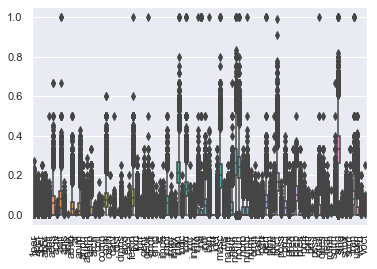

In [13]:
names=list(cv.get_feature_names_out())
names.append('Категория')
sns.boxplot(data=df_eda[names].query('Категория == "Вопрос"'))
plt.xticks(rotation=90)
plt.show()

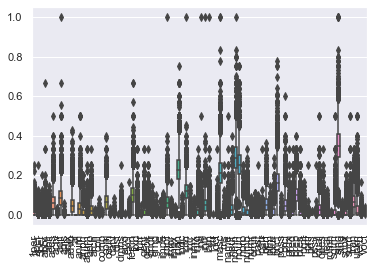

In [14]:
names=list(cv.get_feature_names_out())
names.append('Категория')
sns.boxplot(data=df_eda[names].query('Категория == "Жалоба"'))
plt.xticks(rotation=90)
plt.show()

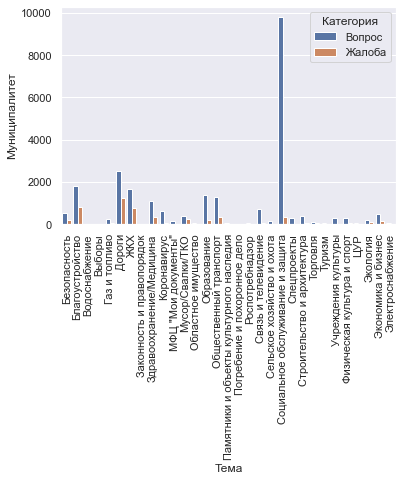

In [15]:
sns.barplot(data=df_eda.groupby(['Тема', 'Категория']).count().reset_index(), x='Тема', y='Муниципалитет', hue='Категория')
plt.xticks(rotation=90)
plt.show()

Text(0.5, 1.0, 'Количество постов по темам')

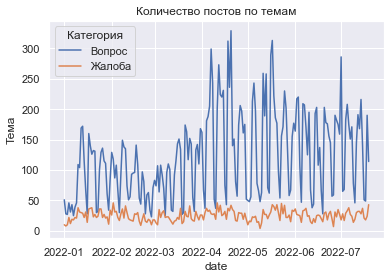

In [16]:
sns.lineplot(data=df_eda.groupby(['date', 'Категория']).count().reset_index(), x='date', y='Тема', hue='Категория')
plt.title('Количество постов по темам')

Text(0.5, 1.0, 'Количество постов по Муниципалитетам')

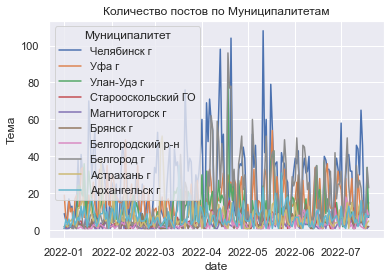

In [17]:
sns.lineplot(data=df_eda[df_eda['Муниципалитет'].isin(main_region_names)].groupby(['date', 'Муниципалитет']).count().reset_index().sort_values('Муниципалитет', ascending=False),
              x='date', y='Тема', hue='Муниципалитет')
plt.title('Количество постов по Муниципалитетам')

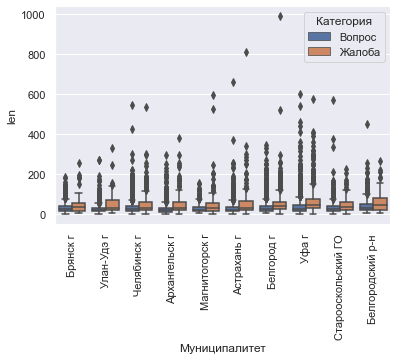

In [18]:
sns.boxplot(data=df_eda[df_eda['Муниципалитет'].isin(main_region_names)], x='Муниципалитет', y='len', hue='Категория')
plt.xticks(rotation=90)
plt.show()

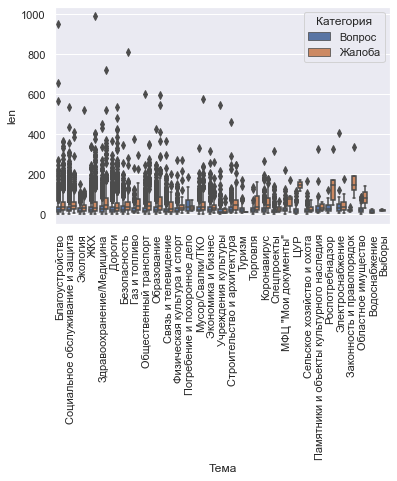

In [19]:
sns.boxplot(data=df_eda, x='Тема', y='len', hue='Категория')
plt.xticks(rotation=90)
plt.show()

<AxesSubplot: xlabel='Категория', ylabel='len'>

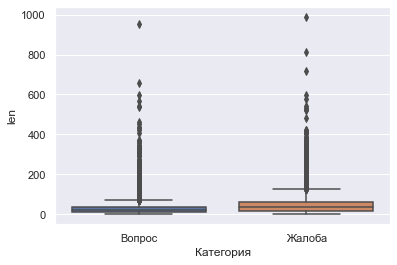

In [20]:
sns.boxplot(data=df_eda, x='Категория', y='len')

In [21]:
df['Категория'].value_counts()

Вопрос    24549
Жалоба     5000
Name: Категория, dtype: int64

In [22]:
df['Муниципалитет'].value_counts()

Челябинск г        5325
Белгород г         3319
Уфа г              3152
Улан-Удэ г         2078
Астрахань г        1378
                   ... 
Ивановский р-н        1
Аргун г               1
Жирятинский р-н       1
Трехгорный-1 г        1
Циолковский г.        1
Name: Муниципалитет, Length: 270, dtype: int64

"Категория", длинна предложения и "Тема" достаточно хороши для классификации. Датасет достаточно сильно несбалансирован.

## ML

In [23]:
df_ml = df.copy()[['X', 'Категория']]
df_ml[F_NAMES] = df.copy()[F_NAMES]

In [24]:
le1 = LabelEncoder()
le2 = LabelEncoder()
le3 = LabelEncoder()

df_ml['Категория'] = le1.fit_transform(df_ml['Категория'])
df_ml['Тема'] = le2.fit_transform(df_ml['Тема'])
df_ml['Муниципалитет'] = le3.fit_transform(df_ml['Муниципалитет'])

In [25]:
le1 = LabelEncoder()
vec = TfidfVectorizer(
    ngram_range=(1,6),
    max_df=0.9,
    min_df=0.001,
)
df_ml = df_ml.dropna()
X = df_ml.drop(columns=['Категория'])
y = df_ml['Категория']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [26]:
vect_train = vec.fit_transform(X_train['X'])
vect_train = pd.DataFrame(vect_train.toarray())
X_train = pd.concat([X_train.drop(columns=['X']).reset_index(drop=True), vect_train], axis=1)

X_test_df = X_test.copy()
vect_test = vec.transform(X_test['X'])
vect_test = pd.DataFrame(vect_test.toarray())
X_test = pd.concat([X_test.drop(columns=['X']).reset_index(drop=True), vect_test], axis=1)

In [27]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22131 entries, 0 to 22130
Columns: 4656 entries, len to 4564
dtypes: float64(4653), int64(3)
memory usage: 786.1 MB


In [28]:
f_names = list(X_train.columns)
X_train = sparse.coo_matrix(X_train)
X_test = sparse.coo_matrix(X_test)

In [29]:
clf = CatBoostClassifier(
                         random_state=42,
                         n_estimators=3000,
                         depth=3,
                         early_stopping_rounds=10,
                         )
clf.fit(X_train, y_train,
        eval_set=(X_test, y_test))

Learning rate set to 0.042226
0:	learn: 0.6648395	test: 0.6654183	best: 0.6654183 (0)	total: 84.9ms	remaining: 4m 14s
1:	learn: 0.6368365	test: 0.6378842	best: 0.6378842 (1)	total: 108ms	remaining: 2m 41s
2:	learn: 0.6123743	test: 0.6140249	best: 0.6140249 (2)	total: 129ms	remaining: 2m 8s
3:	learn: 0.5892545	test: 0.5914159	best: 0.5914159 (3)	total: 150ms	remaining: 1m 52s
4:	learn: 0.5696025	test: 0.5720859	best: 0.5720859 (4)	total: 172ms	remaining: 1m 43s
5:	learn: 0.5496028	test: 0.5524708	best: 0.5524708 (5)	total: 194ms	remaining: 1m 36s
6:	learn: 0.5328343	test: 0.5360092	best: 0.5360092 (6)	total: 216ms	remaining: 1m 32s
7:	learn: 0.5158778	test: 0.5195050	best: 0.5195050 (7)	total: 238ms	remaining: 1m 28s
8:	learn: 0.5053344	test: 0.5091931	best: 0.5091931 (8)	total: 257ms	remaining: 1m 25s
9:	learn: 0.4937158	test: 0.4976763	best: 0.4976763 (9)	total: 280ms	remaining: 1m 23s
10:	learn: 0.4850623	test: 0.4890561	best: 0.4890561 (10)	total: 302ms	remaining: 1m 21s
11:	learn: 

In [30]:
preds = clf.predict(X_test)
preds_train = clf.predict(X_train)

print('Train acc: ', accuracy_score(preds_train, y_train))
print('Acc:', accuracy_score(preds, y_test))
print('Ball acc:', balanced_accuracy_score(preds, y_test))
print()
print(classification_report(y_test, preds, target_names=['Вопрос', 'Жалоба'], digits=4))

Train acc:  0.9029415751660567
Acc: 0.8746102751796123
Ball acc: 0.8135678565594884

              precision    recall  f1-score   support

      Вопрос     0.8893    0.9692    0.9276      6111
      Жалоба     0.7378    0.4179    0.5335      1266

    accuracy                         0.8746      7377
   macro avg     0.8136    0.6935    0.7306      7377
weighted avg     0.8633    0.8746    0.8599      7377



In [31]:
df_fit = pd.DataFrame({'names': f_names, 'imp': clf.feature_importances_})
df_fit.query('imp > 0').sort_values('imp', ascending=False)

,names,imp
89,Тема,20.530614
3108,3017,10.071981
0,len,5.831587
1772,1681,5.091647
1950,1859,4.174325
...,...,...
152,61,0.001910
4524,4433,0.001721
1582,1491,0.001471
1118,1027,0.000982


In [32]:
df_fit = pd.merge(df_fit, pd.DataFrame({'toc': vec.get_feature_names_out()}).reset_index(), left_on='names', right_on='index')
df_fit.query('imp > 0').sort_values('imp', ascending=False)

,names,imp,index,toc
3017,3017,10.071981,3017,подсказать
1681,1681,5.091647,1681,когда
1859,1859,4.174325,1859,ли
2324,2324,2.544724,2324,не
1500,1500,1.873601,1500,или
...,...,...,...,...
61,61,0.001910,61,23
4433,4433,0.001721,4433,что бы
1491,1491,0.001471,1491,из они
1027,1027,0.000982,1027,добрый утро


In [33]:
#pd.set_option('max_colwidth', 800)

In [34]:
# Неправильно предсказанные
X_test_df['preds'] = preds
X_test_df['targ'] = y_test
X_test_df[['X', 'preds', 'targ']].query('preds != targ')

,X,preds,targ
9087,уважаемый в.в если в ваш компетенция не входит...,0,1
13994,когда в архангельск быть штрафовать владелец а...,0,1
23664,"богдан хмельницкий дом √35 магазин пристать , ...",0,1
11624,а кто контейнер убрать ? < br > не стать конте...,0,1
16948,"извинить конечно , а какой смысл к вы обращать...",0,1
...,...,...,...
14806,добрый вечер ! рядом с магазин `` островок `` ...,0,1
27349,"добрый день.кома жаловаться на оператор мтс , ...",0,1
13055,"# отподписчик < br > здравствуйте , не знать к...",1,0
532,а на посёлок строитель ? тоже вокруг один маши...,0,1


With Oversempling


In [35]:
ros = RandomUnderSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

clf = CatBoostClassifier(
                         random_state=42,
                         n_estimators=3000,
                         depth=3,
                         early_stopping_rounds=10,
                         )
clf.fit(X_train, y_train,
        eval_set=(X_test, y_test))

preds = clf.predict(X_test)
preds_train = clf.predict(X_train)

print('Train acc: ', accuracy_score(preds_train, y_train))
print('Acc:', accuracy_score(preds, y_test))
print('Ball acc:', balanced_accuracy_score(preds, y_test))
print()
print(classification_report(y_test, preds, target_names=['Вопрос', 'Жалоба'], digits=4))

Learning rate set to 0.032232
0:	learn: 0.6846063	test: 0.6841422	best: 0.6841422 (0)	total: 10.4ms	remaining: 31.1s
1:	learn: 0.6773142	test: 0.6768874	best: 0.6768874 (1)	total: 19.5ms	remaining: 29.2s
2:	learn: 0.6707301	test: 0.6703016	best: 0.6703016 (2)	total: 28.3ms	remaining: 28.3s
3:	learn: 0.6629822	test: 0.6618347	best: 0.6618347 (3)	total: 37.4ms	remaining: 28s
4:	learn: 0.6563984	test: 0.6549244	best: 0.6549244 (4)	total: 46.7ms	remaining: 27.9s
5:	learn: 0.6509302	test: 0.6497847	best: 0.6497847 (5)	total: 55.4ms	remaining: 27.6s
6:	learn: 0.6457078	test: 0.6449855	best: 0.6449855 (6)	total: 64.8ms	remaining: 27.7s
7:	learn: 0.6396502	test: 0.6385662	best: 0.6385662 (7)	total: 73.8ms	remaining: 27.6s
8:	learn: 0.6340302	test: 0.6328469	best: 0.6328469 (8)	total: 82.9ms	remaining: 27.6s
9:	learn: 0.6292666	test: 0.6285356	best: 0.6285356 (9)	total: 91.7ms	remaining: 27.4s
10:	learn: 0.6238971	test: 0.6227580	best: 0.6227580 (10)	total: 101ms	remaining: 27.5s
11:	learn: 0.6

In [36]:
clf_rand_forest = RandomForestClassifier(
                                        random_state=42,
                                        n_estimators=1000,
                                        max_depth=4,
)
clf_rand_forest.fit(X_train, y_train)

preds = clf_rand_forest.predict(X_test)
preds_train = clf_rand_forest.predict(X_train)

print('Train acc: ', accuracy_score(preds_train, y_train))
print('Acc:', accuracy_score(preds, y_test))
print('Ball acc:', balanced_accuracy_score(preds, y_test))
print()
print(classification_report(y_test, preds, target_names=['Вопрос', 'Жалоба'], digits=4))

Train acc:  0.7680690399137001
Acc: 0.7485427680628982
Ball acc: 0.6574226771481099

              precision    recall  f1-score   support

      Вопрос     0.9339    0.7495    0.8316      6111
      Жалоба     0.3809    0.7441    0.5039      1266

    accuracy                         0.7485      7377
   macro avg     0.6574    0.7468    0.6677      7377
weighted avg     0.8390    0.7485    0.7754      7377



Выводы: 

Наилучшие результаты получились при использовании "catboost" без семплинга датасета.
Качаство классификации оставляет желать лучшего. Низкие значения f1 и recall для категории жалоба указывают на низкое качество классификации.

Проблемы:

В силу спецыфики происхождения текста в нем много уникальных токинов, и конструкций с которыми не справляется стандартный токенизатор.
Датасет сильно не сбалансирован, нехватает данных категории "Жалоба".

Предложения по улутшению:

1. Использовать BERT для улучшения качаства векторизации. (Выполненно в блакноте BERT+catboost)
2. Доработать токенизатор с учетом спецыфики датасета.
3. Коррекция значимости примеров в датасете с учетом учетом важности метрик для бизнеса.